In [1]:
# ✅ Fully improved model with patient-wise splitting and no shuffling across patients

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from sklearn.metrics import classification_report, accuracy_score
import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split

# 📦 Load dataset
path = "C:/Users/RAZER/Desktop/TEMp/New folder/KINECT_dataset_with_qor15.csv"
dataframe = pd.read_csv(path)
dataframe = dataframe[dataframe['walking_speed'] == 'Fast']
dataframe.dropna(subset=['QoR_class'], inplace=True)

# 📌 Graph structure
joints = ['PELVIS', 'SPINE_NAVAL', 'SPINE_CHEST', 'NECK', 'CLAVICLE_LEFT', 'SHOULDER_LEFT',
          'ELBOW_LEFT', 'WRIST_LEFT', 'HAND_LEFT', 'HANDTIP_LEFT', 'THUMB_LEFT',
          'CLAVICLE_RIGHT', 'SHOULDER_RIGHT', 'ELBOW_RIGHT', 'WRIST_RIGHT', 'HAND_RIGHT',
          'HANDTIP_RIGHT', 'THUMB_RIGHT', 'HIP_LEFT', 'KNEE_LEFT', 'ANKLE_LEFT',
          'FOOT_LEFT', 'HIP_RIGHT', 'KNEE_RIGHT', 'ANKLE_RIGHT', 'FOOT_RIGHT',
          'HEAD', 'NOSE', 'EYE_LEFT', 'EAR_LEFT', 'EYE_RIGHT', 'EAR_RIGHT']

edges = [('PELVIS', 'SPINE_NAVAL'), ('SPINE_NAVAL', 'SPINE_CHEST'), ('SPINE_CHEST', 'NECK'),
         ('NECK', 'HEAD'), ('SPINE_CHEST', 'CLAVICLE_LEFT'), ('CLAVICLE_LEFT', 'SHOULDER_LEFT'),
         ('SHOULDER_LEFT', 'ELBOW_LEFT'), ('ELBOW_LEFT', 'WRIST_LEFT'), ('WRIST_LEFT', 'HAND_LEFT'),
         ('HAND_LEFT', 'HANDTIP_LEFT'), ('WRIST_LEFT', 'THUMB_LEFT'), ('SPINE_CHEST', 'CLAVICLE_RIGHT'),
         ('CLAVICLE_RIGHT', 'SHOULDER_RIGHT'), ('SHOULDER_RIGHT', 'ELBOW_RIGHT'), ('ELBOW_RIGHT', 'WRIST_RIGHT'),
         ('WRIST_RIGHT', 'HAND_RIGHT'), ('HAND_RIGHT', 'HANDTIP_RIGHT'), ('WRIST_RIGHT', 'THUMB_RIGHT'),
         ('PELVIS', 'HIP_LEFT'), ('HIP_LEFT', 'KNEE_LEFT'), ('KNEE_LEFT', 'ANKLE_LEFT'),
         ('ANKLE_LEFT', 'FOOT_LEFT'), ('PELVIS', 'HIP_RIGHT'), ('HIP_RIGHT', 'KNEE_RIGHT'),
         ('KNEE_RIGHT', 'ANKLE_RIGHT'), ('ANKLE_RIGHT', 'FOOT_RIGHT'),
         ('HEAD', 'NOSE'), ('HEAD', 'EYE_LEFT'), ('HEAD', 'EYE_RIGHT'), ('HEAD', 'EAR_LEFT'), ('HEAD', 'EAR_RIGHT')]

joint_to_idx = {j: i for i, j in enumerate(joints)}
edge_index = torch.tensor([[joint_to_idx[a], joint_to_idx[b]] for a, b in edges] + 
                          [[joint_to_idx[b], joint_to_idx[a]] for a, b in edges], dtype=torch.long).t()

# 🧱 Dataset
class WindowedSkeletonDataset(torch.utils.data.Dataset):
    def __init__(self, df, window_size=30, stride=15):
        self.samples = []
        self.labels = []
        grouped = df.groupby(['patient_id', 'trial'])
        for _, group in grouped:
            group = group.sort_values('t_uniform')
            if len(group) < window_size:
                continue
            for i in range(0, len(group) - window_size + 1, stride):
                window = group.iloc[i:i+window_size]
                x_seq, aux_seq = [], []
                for _, row in window.iterrows():
                    node_features = [[row[f'{j}_X'], row[f'{j}_Y'], row[f'{j}_Z'], row['t_uniform']] for j in joints]
                    x_seq.append(torch.tensor(node_features, dtype=torch.float))
                    aux_seq.append(torch.tensor([row['left_foot_swing'], row['right_foot_swing'], row['pelvis_pos']], dtype=torch.float))
                label = torch.tensor(window['QoR_class'].mode().values[0], dtype=torch.float)
                self.samples.append((torch.stack(x_seq), torch.stack(aux_seq), label))
                self.labels.append(int(label.item()))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]

# 🔀 Patient-wise split
unique_ids = dataframe['patient_id'].unique()
train_ids, test_ids = train_test_split(unique_ids, test_size=0.3, random_state=42)

train_df = dataframe[dataframe['patient_id'].isin(train_ids)]
test_df  = dataframe[dataframe['patient_id'].isin(test_ids)]







#---------------------------------------------------------------------------------------------------------------------------------------------------------

wind_size = 60
stride_size = 5
b_size = 16

#---------------------------------------------------------------------------------------------------------------------------------------------------------






train_dataset = WindowedSkeletonDataset(train_df,window_size=wind_size, stride=stride_size)
test_dataset  = WindowedSkeletonDataset(test_df,window_size=wind_size, stride=stride_size)

# 📦 Dataloaders (no shuffle)
train_loader = DataLoader(train_dataset, batch_size=b_size)
test_loader  = DataLoader(test_dataset, batch_size=b_size)

# 🧠 Model
class WindowedSTGCN(nn.Module):
    def __init__(self, in_channels, hidden_channels):
        super().__init__()
        self.gcn = GCNConv(in_channels, hidden_channels)
        self.lstm = nn.LSTM(hidden_channels, hidden_channels, batch_first=True)
        self.aux_fc = nn.Linear(3, hidden_channels)
        self.classifier = nn.Linear(2 * hidden_channels, 1)

    def forward(self, x_seq, aux_seq):
        B, T, N, feat_dim = x_seq.shape
        x_seq = x_seq.view(B * T * N, feat_dim)
        full_edge_index = torch.cat([edge_index + b * N for b in range(B * T)], dim=1).to(x_seq.device)
        x = F.relu(self.gcn(x_seq, full_edge_index))
        x = x.view(B, T, N, -1).mean(2)
        x, _ = self.lstm(x)
        x = x[:, -1, :]
        aux = F.relu(self.aux_fc(aux_seq.mean(1)))
        return self.classifier(torch.cat([x, aux], dim=-1)).squeeze()

# ✅ Training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = WindowedSTGCN(in_channels=4, hidden_channels=128).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.BCEWithLogitsLoss()

for epoch in range(1, 100):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for x_seq, aux_seq, y in train_loader:
        x_seq, aux_seq, y = x_seq.to(device), aux_seq.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x_seq, aux_seq)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * y.size(0)
        correct += ((torch.sigmoid(out) >= 0.5).float() == y).sum().item()
        total += y.size(0)
    print(f"Epoch {epoch:03d} | Loss: {total_loss / total:.4f} | Accuracy: {correct / total:.4f}")

# 🧪 Final Evaluation
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for x_seq, aux_seq, y in test_loader:
        x_seq, aux_seq = x_seq.to(device), aux_seq.to(device)
        out = torch.sigmoid(model(x_seq, aux_seq))
        pred = (out >= 0.5).float()
        y_true.extend(y.cpu().numpy())
        y_pred.extend(pred.cpu().view(-1).numpy())


print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=["Good (0)", "Not Good (1)"]))

Epoch 001 | Loss: 67.9072 | Accuracy: 0.4609
Epoch 002 | Loss: 6.4431 | Accuracy: 0.4953
Epoch 003 | Loss: 6.4215 | Accuracy: 0.4921
Epoch 004 | Loss: 6.2769 | Accuracy: 0.4937
Epoch 005 | Loss: 6.1677 | Accuracy: 0.4937
Epoch 006 | Loss: 6.1246 | Accuracy: 0.4949
Epoch 007 | Loss: 6.1074 | Accuracy: 0.4939
Epoch 008 | Loss: 6.0926 | Accuracy: 0.4971
Epoch 009 | Loss: 6.0743 | Accuracy: 0.4995
Epoch 010 | Loss: 6.0580 | Accuracy: 0.4993
Epoch 011 | Loss: 6.0373 | Accuracy: 0.4969
Epoch 012 | Loss: 6.0191 | Accuracy: 0.4983
Epoch 013 | Loss: 6.0047 | Accuracy: 0.4993
Epoch 014 | Loss: 5.9903 | Accuracy: 0.4979
Epoch 015 | Loss: 5.9759 | Accuracy: 0.4997
Epoch 016 | Loss: 5.9660 | Accuracy: 0.5001
Epoch 017 | Loss: 5.9550 | Accuracy: 0.4985
Epoch 018 | Loss: 5.9447 | Accuracy: 0.4995
Epoch 019 | Loss: 5.9362 | Accuracy: 0.5007
Epoch 020 | Loss: 5.9292 | Accuracy: 0.5013
Epoch 021 | Loss: 5.9196 | Accuracy: 0.5015
Epoch 022 | Loss: 5.9096 | Accuracy: 0.5021
Epoch 023 | Loss: 5.9004 | Accu

In [2]:
from collections import defaultdict
import pandas as pd
import torch

model.eval()
patient_results = defaultdict(list)

# Align test_df index to help lookup patient IDs
test_df = test_df.reset_index(drop=True)

with torch.no_grad():
    for i in range(len(test_dataset)):
        x_seq, aux_seq, y = test_dataset[i]
        patient_id = test_df.iloc[i]['patient_id']
        x_seq, aux_seq = x_seq.unsqueeze(0).to(device), aux_seq.unsqueeze(0).to(device)
        output = model(x_seq, aux_seq)
        prob = torch.sigmoid(output).item()
        pred_label = int(prob >= 0.5)
        true_label = int(y.item())

        patient_results[patient_id].append({
            'pred': pred_label,
            'true': true_label,
            'prob': prob
        })

# Build summary per patient
summary = []
for pid, records in patient_results.items():
    preds = [r['pred'] for r in records]
    trues = [r['true'] for r in records]
    probs = [r['prob'] for r in records]

    correct_count = sum(p == t for p, t in zip(preds, trues))
    total = len(records)
    valid_percentage = 100 * correct_count / total
    invalid_percentage = 100 - valid_percentage

    summary.append({
        'PatientID': pid,
        'Predicted_QoR_class': max(set(preds), key=preds.count),
        'Actual_QoR_class': max(set(trues), key=trues.count),
        'valid_percentage': round(valid_percentage, 2),
        'invalid_percentage': round(invalid_percentage, 2),
        'average_model_output': round(sum(probs) / len(probs), 6)
    })

# Convert to DataFrame and view
report_df = pd.DataFrame(summary).sort_values(by='PatientID').reset_index(drop=True)
display(report_df)

# Save if needed
# report_df.to_csv("QoR_Per_Patient_Report.csv", index=False)


,PatientID,Predicted_QoR_class,Actual_QoR_class,valid_percentage,invalid_percentage,average_model_output
0,001-LO,0,1,47.55,52.45,0.016049
1,005-GP,0,0,80.23,19.77,0.008069
2,006-TR,0,0,100.00,0.00,0.003988
3,010-RA,0,0,98.77,1.23,0.020157


#---------------------------------------------_____________________________________________________________________

In [5]:
path = "C:/Users/RAZER/Desktop/TEMp/New folder/KINECT_dataset_with_qor15.csv"

In [6]:
# ✅ Clean Baseline QoR Model with Multi-layer GCN + LSTM + Focal Loss + Patient-wise Evaluation + Classification Report

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.loader import DataLoader
from sklearn.metrics import classification_report, brier_score_loss
import pandas as pd
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

# 🔧 Config
WINDOW_SIZE = 120
STRIDE = 10
BATCH_SIZE = 16
EPOCHS = 100
LEARNING_RATE = 1e-4

# 📦 Load Data
df = pd.read_csv(path)
df = df[df['walking_speed'] == 'Fast']
df.dropna(subset=['QoR_class'], inplace=True)

# 🧱 Graph Structure
joints = ['PELVIS', 'SPINE_NAVAL', 'SPINE_CHEST', 'NECK', 'CLAVICLE_LEFT', 'SHOULDER_LEFT',
          'ELBOW_LEFT', 'WRIST_LEFT', 'HAND_LEFT', 'HANDTIP_LEFT', 'THUMB_LEFT',
          'CLAVICLE_RIGHT', 'SHOULDER_RIGHT', 'ELBOW_RIGHT', 'WRIST_RIGHT', 'HAND_RIGHT',
          'HANDTIP_RIGHT', 'THUMB_RIGHT', 'HIP_LEFT', 'KNEE_LEFT', 'ANKLE_LEFT',
          'FOOT_LEFT', 'HIP_RIGHT', 'KNEE_RIGHT', 'ANKLE_RIGHT', 'FOOT_RIGHT',
          'HEAD', 'NOSE', 'EYE_LEFT', 'EAR_LEFT', 'EYE_RIGHT', 'EAR_RIGHT']

edges = [('PELVIS', 'SPINE_NAVAL'), ('SPINE_NAVAL', 'SPINE_CHEST'), ('SPINE_CHEST', 'NECK'),
         ('NECK', 'HEAD'), ('SPINE_CHEST', 'CLAVICLE_LEFT'), ('CLAVICLE_LEFT', 'SHOULDER_LEFT'),
         ('SHOULDER_LEFT', 'ELBOW_LEFT'), ('ELBOW_LEFT', 'WRIST_LEFT'), ('WRIST_LEFT', 'HAND_LEFT'),
         ('HAND_LEFT', 'HANDTIP_LEFT'), ('WRIST_LEFT', 'THUMB_LEFT'), ('SPINE_CHEST', 'CLAVICLE_RIGHT'),
         ('CLAVICLE_RIGHT', 'SHOULDER_RIGHT'), ('SHOULDER_RIGHT', 'ELBOW_RIGHT'), ('ELBOW_RIGHT', 'WRIST_RIGHT'),
         ('WRIST_RIGHT', 'HAND_RIGHT'), ('HAND_RIGHT', 'HANDTIP_RIGHT'), ('WRIST_RIGHT', 'THUMB_RIGHT'),
         ('PELVIS', 'HIP_LEFT'), ('HIP_LEFT', 'KNEE_LEFT'), ('KNEE_LEFT', 'ANKLE_LEFT'),
         ('ANKLE_LEFT', 'FOOT_LEFT'), ('PELVIS', 'HIP_RIGHT'), ('HIP_RIGHT', 'KNEE_RIGHT'),
         ('KNEE_RIGHT', 'ANKLE_RIGHT'), ('ANKLE_RIGHT', 'FOOT_RIGHT'),
         ('HEAD', 'NOSE'), ('HEAD', 'EYE_LEFT'), ('HEAD', 'EYE_RIGHT'),
         ('HEAD', 'EAR_LEFT'), ('HEAD', 'EAR_RIGHT')]

joint_to_idx = {j: i for i, j in enumerate(joints)}
edge_index = torch.tensor([[joint_to_idx[a], joint_to_idx[b]] for a, b in edges] +
                          [[joint_to_idx[b], joint_to_idx[a]] for a, b in edges], dtype=torch.long).t()

# 📚 Dataset
class WindowedDataset(torch.utils.data.Dataset):
    def __init__(self, df, window_size, stride):
        self.samples = []
        grouped = df.groupby(['patient_id', 'trial'])
        for (pid, trial), group in grouped:
            group = group.sort_values('t_uniform')
            if len(group) < window_size:
                continue
            for i in range(0, len(group) - window_size + 1, stride):
                window = group.iloc[i:i+window_size]
                x_seq = torch.tensor([
                    [[row[f'{j}_X'], row[f'{j}_Y'], row[f'{j}_Z'], row['t_uniform']] for j in joints]
                    for _, row in window.iterrows()
                ], dtype=torch.float)
                aux_seq = torch.tensor([
                    [row['left_foot_swing'], row['right_foot_swing'], row['pelvis_pos']] 
                    for _, row in window.iterrows()
                ], dtype=torch.float)
                label = torch.tensor(window['QoR_class'].mode().values[0], dtype=torch.float)
                self.samples.append((x_seq, aux_seq, label, pid))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]

# 🔀 Split
train_ids, test_ids = train_test_split(df['patient_id'].unique(), test_size=0.3, random_state=42)
train_df = df[df['patient_id'].isin(train_ids)]
test_df = df[df['patient_id'].isin(test_ids)]

train_dataset = WindowedDataset(train_df, WINDOW_SIZE, STRIDE)
test_dataset = WindowedDataset(test_df, WINDOW_SIZE, STRIDE)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# 🧠 Model
class GCN_LSTM_Model(nn.Module):
    def __init__(self, in_channels=4, hidden_channels=128):
        super().__init__()
        self.gcn1 = GCNConv(in_channels, hidden_channels)
        self.gcn2 = GCNConv(hidden_channels, hidden_channels)
        self.lstm = nn.LSTM(hidden_channels, hidden_channels, batch_first=True)
        self.aux_fc = nn.Linear(3, hidden_channels)
        self.classifier = nn.Linear(2 * hidden_channels, 1)

    def forward(self, x_seq, aux_seq):
        B, T, N, feat_dim = x_seq.shape
        x_seq = x_seq.view(B * T * N, feat_dim)
        full_edge_index = torch.cat([edge_index + b * N for b in range(B * T)], dim=1).to(x_seq.device)
        x = F.relu(self.gcn1(x_seq, full_edge_index))
        x = F.relu(self.gcn2(x, full_edge_index))
        x = x.view(B, T, N, -1).mean(2)
        x, _ = self.lstm(x)
        aux = F.relu(self.aux_fc(aux_seq.mean(1)))
        return self.classifier(torch.cat([x[:, -1, :], aux], dim=-1)).view(-1)

# 🎯 Focal Loss
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        BCE = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-BCE)
        return (self.alpha * (1 - pt) ** self.gamma * BCE).mean()

# 🚀 Training
model = GCN_LSTM_Model().to('cuda')
criterion = FocalLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

for epoch in range(EPOCHS):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for x_seq, aux_seq, y, _ in train_dataset:
        x_seq, aux_seq, y = x_seq.unsqueeze(0).to('cuda'), aux_seq.unsqueeze(0).to('cuda'), y.unsqueeze(0).to('cuda')
        optimizer.zero_grad()
        out = model(x_seq, aux_seq)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        correct += ((torch.sigmoid(out) >= 0.5).float() == y).sum().item()
        total += 1
    print(f"Epoch {epoch+1:03d} | Loss: {total_loss/total:.4f} | Accuracy: {correct/total:.4f}")

# 📊 Per-Patient Evaluation + Classification Report
model.eval()
patient_results = defaultdict(list)
y_true_global, y_pred_global = [], []

with torch.no_grad():
    for x_seq, aux_seq, y, pid in test_dataset:
        x_seq, aux_seq = x_seq.unsqueeze(0).to('cuda'), aux_seq.unsqueeze(0).to('cuda')
        out = torch.sigmoid(model(x_seq, aux_seq)).cpu().item()
        pred = int(out >= 0.5)
        y_true_global.append(int(y.item()))
        y_pred_global.append(pred)
        patient_results[pid].append({'pred': pred, 'true': int(y.item()), 'prob': out})

summary = []
for pid, recs in patient_results.items():
    preds = [r['pred'] for r in recs]
    trues = [r['true'] for r in recs]
    probs = [r['prob'] for r in recs]
    valid = sum(p == t for p, t in zip(preds, trues))
    summary.append({
        'PatientID': pid,
        'Predicted_QoR_class': max(set(preds), key=preds.count),
        'Actual_QoR_class': max(set(trues), key=trues.count),
        'valid_percentage': round(100 * valid / len(trues), 2),
        'average_model_output': round(sum(probs)/len(probs), 4)
    })

report_df = pd.DataFrame(summary).sort_values('PatientID')
print(report_df)

# 🧾 Global Classification Report
print("\nClassification Report (Global):")
print(classification_report(y_true_global, y_pred_global, digits=4))

# 📈 Calibration Curve
all_probs = []
all_labels = []
with torch.no_grad():
    for x_seq, aux_seq, y, _ in test_dataset:
        x_seq, aux_seq = x_seq.unsqueeze(0).to('cuda'), aux_seq.unsqueeze(0).to('cuda')
        prob = torch.sigmoid(model(x_seq, aux_seq)).cpu().item()
        all_probs.append(prob)
        all_labels.append(y.item())

prob_true, prob_pred = calibration_curve(all_labels, all_probs, n_bins=10)
plt.plot(prob_pred, prob_true, marker='o', label='Calibration')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly Calibrated')
plt.xlabel('Predicted Probability')
plt.ylabel('True Probability')
plt.title('Calibration Curve')
plt.legend()
plt.grid(True)
plt.show()


Epoch 001 | Loss: 14.4539 | Accuracy: 0.7111
Epoch 002 | Loss: 12.7325 | Accuracy: 0.7208
Epoch 003 | Loss: 13.0106 | Accuracy: 0.7269
Epoch 004 | Loss: 12.4809 | Accuracy: 0.7284
Epoch 005 | Loss: 12.0905 | Accuracy: 0.7330
Epoch 006 | Loss: 11.9643 | Accuracy: 0.7360
Epoch 007 | Loss: 12.0095 | Accuracy: 0.7350
Epoch 008 | Loss: 11.6909 | Accuracy: 0.7365
Epoch 009 | Loss: 11.4118 | Accuracy: 0.7360
Epoch 010 | Loss: 11.5220 | Accuracy: 0.7345
Epoch 011 | Loss: 10.6283 | Accuracy: 0.7365
Epoch 012 | Loss: 10.8522 | Accuracy: 0.7365
Epoch 013 | Loss: 10.4358 | Accuracy: 0.7355
Epoch 014 | Loss: 10.6923 | Accuracy: 0.7335
Epoch 015 | Loss: 10.4785 | Accuracy: 0.7330
Epoch 016 | Loss: 10.1770 | Accuracy: 0.7345
Epoch 017 | Loss: 10.1496 | Accuracy: 0.7335
Epoch 018 | Loss: 10.3833 | Accuracy: 0.7274
Epoch 019 | Loss: 9.2924 | Accuracy: 0.7370
Epoch 020 | Loss: 9.7750 | Accuracy: 0.7289
Epoch 021 | Loss: 9.3985 | Accuracy: 0.7294
Epoch 022 | Loss: 9.2923 | Accuracy: 0.7294
Epoch 023 | Lo

KeyboardInterrupt: 

In [1]:
path = "C:/Users/RAZER/Desktop/TEMp/New folder/KINECT_dataset_with_qor15.csv"

Epoch 001 | Loss: 16.4358 | Accuracy: 0.7426
Epoch 002 | Loss: 16.7324 | Accuracy: 0.7380
Epoch 003 | Loss: 17.1367 | Accuracy: 0.7340
Epoch 004 | Loss: 15.7352 | Accuracy: 0.7386
Epoch 005 | Loss: 15.9277 | Accuracy: 0.7350
Epoch 006 | Loss: 15.3328 | Accuracy: 0.7406
Epoch 007 | Loss: 15.0367 | Accuracy: 0.7350
Epoch 008 | Loss: 15.3083 | Accuracy: 0.7330
Epoch 009 | Loss: 14.7806 | Accuracy: 0.7350
Epoch 010 | Loss: 14.5843 | Accuracy: 0.7325
Epoch 011 | Loss: 13.7585 | Accuracy: 0.7355
Epoch 012 | Loss: 14.0738 | Accuracy: 0.7340
Epoch 013 | Loss: 13.6788 | Accuracy: 0.7314
Epoch 014 | Loss: 13.1025 | Accuracy: 0.7319
Epoch 015 | Loss: 13.1432 | Accuracy: 0.7325
Epoch 016 | Loss: 12.9186 | Accuracy: 0.7335
Epoch 017 | Loss: 12.6615 | Accuracy: 0.7335
Epoch 018 | Loss: 12.7285 | Accuracy: 0.7319
Epoch 019 | Loss: 12.6134 | Accuracy: 0.7345
Epoch 020 | Loss: 12.5492 | Accuracy: 0.7340
Epoch 021 | Loss: 12.0429 | Accuracy: 0.7335
Epoch 022 | Loss: 12.2003 | Accuracy: 0.7319
Epoch 023 

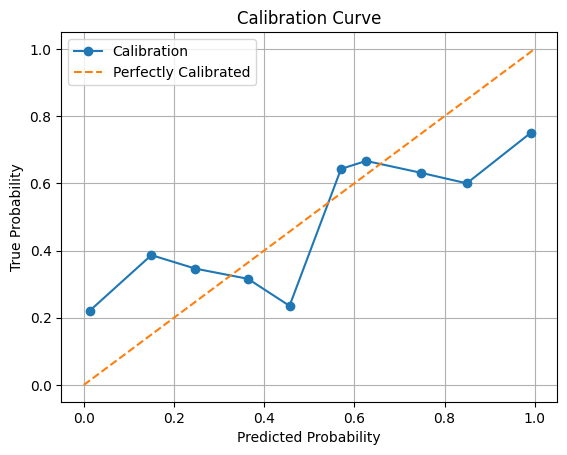

In [3]:
# ✅ Clean Baseline QoR Model with Multi-layer GCN + LSTM + Focal Loss + Patient-wise Evaluation + Classification Report

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.loader import DataLoader
from sklearn.metrics import classification_report, brier_score_loss
import pandas as pd
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

# 🔧 Config
WINDOW_SIZE = 120
STRIDE = 10
BATCH_SIZE = 16
EPOCHS = 100
LEARNING_RATE = 1e-4

# 📦 Load Data

df = pd.read_csv(path)
df = df[df['walking_speed'] == 'Fast']
df.dropna(subset=['QoR_class'], inplace=True)

# 🧱 Graph Structure
joints = ['PELVIS', 'SPINE_NAVAL', 'SPINE_CHEST', 'NECK', 'CLAVICLE_LEFT', 'SHOULDER_LEFT',
          'ELBOW_LEFT', 'WRIST_LEFT', 'HAND_LEFT', 'HANDTIP_LEFT', 'THUMB_LEFT',
          'CLAVICLE_RIGHT', 'SHOULDER_RIGHT', 'ELBOW_RIGHT', 'WRIST_RIGHT', 'HAND_RIGHT',
          'HANDTIP_RIGHT', 'THUMB_RIGHT', 'HIP_LEFT', 'KNEE_LEFT', 'ANKLE_LEFT',
          'FOOT_LEFT', 'HIP_RIGHT', 'KNEE_RIGHT', 'ANKLE_RIGHT', 'FOOT_RIGHT',
          'HEAD', 'NOSE', 'EYE_LEFT', 'EAR_LEFT', 'EYE_RIGHT', 'EAR_RIGHT']

edges = [('PELVIS', 'SPINE_NAVAL'), ('SPINE_NAVAL', 'SPINE_CHEST'), ('SPINE_CHEST', 'NECK'),
         ('NECK', 'HEAD'), ('SPINE_CHEST', 'CLAVICLE_LEFT'), ('CLAVICLE_LEFT', 'SHOULDER_LEFT'),
         ('SHOULDER_LEFT', 'ELBOW_LEFT'), ('ELBOW_LEFT', 'WRIST_LEFT'), ('WRIST_LEFT', 'HAND_LEFT'),
         ('HAND_LEFT', 'HANDTIP_LEFT'), ('WRIST_LEFT', 'THUMB_LEFT'), ('SPINE_CHEST', 'CLAVICLE_RIGHT'),
         ('CLAVICLE_RIGHT', 'SHOULDER_RIGHT'), ('SHOULDER_RIGHT', 'ELBOW_RIGHT'), ('ELBOW_RIGHT', 'WRIST_RIGHT'),
         ('WRIST_RIGHT', 'HAND_RIGHT'), ('HAND_RIGHT', 'HANDTIP_RIGHT'), ('WRIST_RIGHT', 'THUMB_RIGHT'),
         ('PELVIS', 'HIP_LEFT'), ('HIP_LEFT', 'KNEE_LEFT'), ('KNEE_LEFT', 'ANKLE_LEFT'),
         ('ANKLE_LEFT', 'FOOT_LEFT'), ('PELVIS', 'HIP_RIGHT'), ('HIP_RIGHT', 'KNEE_RIGHT'),
         ('KNEE_RIGHT', 'ANKLE_RIGHT'), ('ANKLE_RIGHT', 'FOOT_RIGHT'),
         ('HEAD', 'NOSE'), ('HEAD', 'EYE_LEFT'), ('HEAD', 'EYE_RIGHT'),
         ('HEAD', 'EAR_LEFT'), ('HEAD', 'EAR_RIGHT')]

joint_to_idx = {j: i for i, j in enumerate(joints)}
edge_index = torch.tensor([[joint_to_idx[a], joint_to_idx[b]] for a, b in edges] +
                          [[joint_to_idx[b], joint_to_idx[a]] for a, b in edges], dtype=torch.long).t()

# 📚 Dataset
class WindowedDataset(torch.utils.data.Dataset):
    def __init__(self, df, window_size, stride):
        self.samples = []
        grouped = df.groupby(['patient_id', 'trial'])
        for (pid, trial), group in grouped:
            group = group.sort_values('t_uniform')
            if len(group) < window_size:
                continue
            for i in range(0, len(group) - window_size + 1, stride):
                window = group.iloc[i:i+window_size]
                x_seq = torch.tensor([
                    [[row[f'{j}_X'], row[f'{j}_Y'], row[f'{j}_Z'], row['t_uniform']] for j in joints]
                    for _, row in window.iterrows()
                ], dtype=torch.float)
                aux_seq = torch.tensor([
                    [row['left_foot_swing'], row['right_foot_swing'], row['pelvis_pos']] 
                    for _, row in window.iterrows()
                ], dtype=torch.float)
                label = torch.tensor(window['QoR_class'].mode().values[0], dtype=torch.float)
                self.samples.append((x_seq, aux_seq, label, pid))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]

# 🔀 Split
train_ids, test_ids = train_test_split(df['patient_id'].unique(), test_size=0.3, random_state=42)
train_df = df[df['patient_id'].isin(train_ids)]
test_df = df[df['patient_id'].isin(test_ids)]

train_dataset = WindowedDataset(train_df, WINDOW_SIZE, STRIDE)
test_dataset = WindowedDataset(test_df, WINDOW_SIZE, STRIDE)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# 🧠 Model
class GCN_LSTM_Model(nn.Module):
    def __init__(self, in_channels=4, hidden_channels=128):
        super().__init__()
        self.gcn1 = GCNConv(in_channels, hidden_channels)
        self.gcn2 = GCNConv(hidden_channels, hidden_channels)
        self.lstm = nn.LSTM(hidden_channels, hidden_channels, batch_first=True)
        self.aux_fc = nn.Linear(3, hidden_channels)
        self.classifier = nn.Linear(2 * hidden_channels, 1)

    def forward(self, x_seq, aux_seq):
        B, T, N, feat_dim = x_seq.shape
        x_seq = x_seq.view(B * T * N, feat_dim)
        full_edge_index = torch.cat([edge_index + b * N for b in range(B * T)], dim=1).to(x_seq.device)
        x = F.relu(self.gcn1(x_seq, full_edge_index))
        x = F.relu(self.gcn2(x, full_edge_index))
        x = x.view(B, T, N, -1).mean(2)
        x, _ = self.lstm(x)
        aux = F.relu(self.aux_fc(aux_seq.mean(1)))
        return self.classifier(torch.cat([x[:, -1, :], aux], dim=-1)).view(-1)

# 🎯 Focal Loss
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        BCE = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-BCE)
        return (self.alpha * (1 - pt) ** self.gamma * BCE).mean()

# 🚀 Training
model = GCN_LSTM_Model().to('cuda')
criterion = FocalLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

for epoch in range(EPOCHS):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for x_seq, aux_seq, y, _ in train_dataset:
        x_seq, aux_seq, y = x_seq.unsqueeze(0).to('cuda'), aux_seq.unsqueeze(0).to('cuda'), y.unsqueeze(0).to('cuda')
        optimizer.zero_grad()
        out = model(x_seq, aux_seq)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        correct += ((torch.sigmoid(out) >= 0.5).float() == y).sum().item()
        total += 1
    print(f"Epoch {epoch+1:03d} | Loss: {total_loss/total:.4f} | Accuracy: {correct/total:.4f}")

# 📊 Per-Patient Evaluation + Classification Report
model.eval()
patient_results = defaultdict(list)
y_true_global, y_pred_global = [], []

with torch.no_grad():
    for x_seq, aux_seq, y, pid in test_dataset:
        x_seq, aux_seq = x_seq.unsqueeze(0).to('cuda'), aux_seq.unsqueeze(0).to('cuda')
        out = torch.sigmoid(model(x_seq, aux_seq)).cpu().item()
        pred = int(out >= 0.5)
        y_true_global.append(int(y.item()))
        y_pred_global.append(pred)
        patient_results[pid].append({'pred': pred, 'true': int(y.item()), 'prob': out})

summary = []
for pid, recs in patient_results.items():
    preds = [r['pred'] for r in recs]
    trues = [r['true'] for r in recs]
    probs = [r['prob'] for r in recs]
    valid = sum(p == t for p, t in zip(preds, trues))
    summary.append({
        'PatientID': pid,
        'Predicted_QoR_class': max(set(preds), key=preds.count),
        'Actual_QoR_class': max(set(trues), key=trues.count),
        'valid_percentage': round(100 * valid / len(trues), 2),
        'average_model_output': round(sum(probs)/len(probs), 4)
    })

report_df = pd.DataFrame(summary).sort_values('PatientID')
print(report_df)

# 🧾 Global Classification Report
print("\nClassification Report (Global):")
print(classification_report(y_true_global, y_pred_global, digits=4))

# 📈 Calibration Curve
all_probs = []
all_labels = []
with torch.no_grad():
    for x_seq, aux_seq, y, _ in test_dataset:
        x_seq, aux_seq = x_seq.unsqueeze(0).to('cuda'), aux_seq.unsqueeze(0).to('cuda')
        prob = torch.sigmoid(model(x_seq, aux_seq)).cpu().item()
        all_probs.append(prob)
        all_labels.append(y.item())

prob_true, prob_pred = calibration_curve(all_labels, all_probs, n_bins=10)
plt.plot(prob_pred, prob_true, marker='o', label='Calibration')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly Calibrated')
plt.xlabel('Predicted Probability')
plt.ylabel('True Probability')
plt.title('Calibration Curve')
plt.legend()
plt.grid(True)
plt.show()
